In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Conv1D, LSTM, MaxPool2D, Flatten, InputLayer, Reshape, TimeDistributed
from tensorflow.keras.models import Sequential, load_model
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

load_data = True
load_model_from_file = False

# data_path = os.path.join('data_road','training')
data_path = os.path.join('E:', '595DeepLearning', 'TermProject', 'data_road','training')
training_data_path = os.path.join(data_path, "image_2")
label_data_path = os.path.join(data_path, "gt_image_2")
print(training_data_path)
print(label_data_path)

def create_model():
    model = Sequential([
        InputLayer(input_shape=(160,600,5)),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        MaxPool2D(),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        MaxPool2D(),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        MaxPool2D(),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        TimeDistributed(LSTM(64, return_sequences=True)),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        TimeDistributed(LSTM(64, return_sequences=True)),
        Conv2D(64, (1,5), strides=(1,4), activation='relu'),
        Conv2D(1, (1,4), activation='relu'),
        Flatten(),
        Dense(600, activation='linear')
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

def crop_image(image):
    """
    Crop center 600x160 of the image and recale pixel values to [0,1]
    """
    height, width, _ = image.shape
    ymin = int(height/2-80)
    ymax = int(height/2+80)
    xmin = int(width/2-300)
    xmax = int(width/2+300)
    cropped = image[ymin:ymax, xmin:xmax]
    return cropped

def resize_image(image):
    """
    Resize image to 600x160 and recale pixel values to [0,1]
    """
    resized = cv2.resize(image, dsize=(600, 160), interpolation=cv2.INTER_CUBIC)
    return resized

def process_and_normalize_image(image):
    image = image.astype('float32')
    image /= 255.0
    return image


E:595DeepLearning\TermProject\data_road\training\image_2
E:595DeepLearning\TermProject\data_road\training\gt_image_2


In [2]:
names_df = pd.DataFrame(columns=('image_path', 'label_path'))
image_paths = os.listdir(training_data_path)

for image_filename in image_paths:
    x = image_filename.split("_")
    label_path = "_".join([x[0], "road", x[1]])
    dict1 = {'image_path': image_filename, 'label_path': label_path}
    names_df = names_df.append(dict1, ignore_index = True)
    


In [3]:
# Prepare training data

if not load_data:
    # Get all filenames
    image_paths = os.listdir(training_data_path)

    plot_train_images = False
    resized_input_image_array = []
    cropped_input_image_array = []

    counter = 0
    for idx, values in names_df.iterrows():
        image_filename = values.image_path
        counter += 1
        if counter % 20 == 0:
            print("Processed {} of {} images".format(counter, len(names_df.index)))
        image_path = os.path.join(training_data_path, image_filename)

        # Load image and create resized and cropped versions
        image = cv2.imread(image_path)
        resized_imshow = resize_image(image)
        resized = process_and_normalize_image(resized_imshow)
        cropped_imshow = crop_image(image)
        cropped = process_and_normalize_image(cropped_imshow)

        # Prepare the 4th and 5th dimensions which will be horizontal and verticles indices respectively
        # Refer to https://arxiv.org/pdf/1808.04450.pdf section "IV.B.1 Preprocessing"
        rows = np.ndarray([160,600])
        for i in range(160):
            rows[i, :] = i+1  * np.ones([600])
        columns = np.ndarray([160,600])
        for i in range(600):
            columns[:, i] = i+1 * np.ones([160])
        rows = np.expand_dims(rows, 2)
        columns = np.expand_dims(columns, 2)

        # Add row and column dimensions to our images to create 600x160x5 input tensors
        image_tensor_resized = np.concatenate([resized, rows, columns], axis=2)
        image_tensor_cropped = np.concatenate([cropped, rows, columns], axis=2)

        # Plot images if boolean above is set to True
        # Should only do this if processing a couple of images otherwise matplotlip won't be happy with YOU!
        if plot_train_images:
            fig, (ax1, ax2) = plt.subplots(1,2)
            ax1.imshow(image_tensor_resized[:,:,0:3])
            ax1.set_title("resized")
            ax2.imshow(image_tensor_cropped[:,:,0:3])
            ax2.set_title("cropped")

        # Add the input tensors to the data arrays
        resized_input_image_array.append(image_tensor_resized)
        cropped_input_image_array.append(image_tensor_cropped)
    print("Processed {} of {} labels".format(counter, len(names_df.index)))


In [4]:
# Prepare training labels

if not load_data:
    # Get all filenames
    label_paths = os.listdir(label_data_path)

    plot_label_images = False
    resized_label_array = []
    cropped_label_array = []

    # Loop through all images in the labeled picture directory
    counter = 0
    for idx, values in names_df.iterrows():
        image_filename = values.label_path
    #     print(label_image)
    #     print("road" not in label_image)
    #     if "road" not in label_image:
    #         print("skipping")
    #         continue
        counter += 1
        if counter % 20 == 0:
            print("Processed {} of {} labels".format(counter, len(names_df.index)))

        # Load the image and create a resized and cropped version
        image_path = os.path.join(label_data_path, image_filename)
        image = cv2.imread(image_path)
        resized_imshow = resize_image(image)
        resized = process_and_normalize_image(resized_imshow)
        cropped_imshow = crop_image(image)
        cropped = process_and_normalize_image(cropped_imshow)

        # Initialize the 600x1x1 ndarray to be used as the label for this data point
        # The value is the height of the column where the road borders non-road
        resized_label_img = np.ndarray([600])
        cropped_label_img = np.ndarray([600])

        # Loop through each column of the image to see where the road segmentation begins in the label
        for i in range(resized.shape[1]):
            # Check the through the resized image to see where the segmentation begins
            for j in range(resized.shape[0]):
                if np.array_equiv(resized[j,i],[1.,0.,1.]):
                    break
            resized_label_img[i] = j+1

            # Check through the cropped image to see where the segmentation begins
            for j in range(resized.shape[0]):
                if np.array_equiv(cropped[j,i],[1.,0.,1.]):
                    break
            cropped_label_img[i] = j+1

        # Add the 600x1x1 label to the label array
        resized_label_array.append(resized_label_img)
        cropped_label_array.append(cropped_label_img)

        # Plot images if boolean above is set to True
        # Should only do this if processing a couple of images otherwise matplotlip won't be happy with YOU, yes YOU!!
        if plot_label_images:
            fig, (ax1) = plt.subplots(1,2)
            ax1.imshow(resized)
            ax1.set_title("resized label")
            ax2.imshow(cropped)
            ax2.set_title("cropped label")
    print("Processed {} of {} labels".format(counter, len(names_df.index)))



In [5]:
if not load_data:
    # Convert data and label arrays to nparrays before feeding it to the models
    resized_input_image_array_np = np.array(resized_input_image_array)
    resized_input_image_array_np = resized_input_image_array_np.astype('float32')
    cropped_input_image_array_np = np.array(cropped_input_image_array)
    cropped_input_image_array_np = cropped_input_image_array_np.astype('float32')
    resized_label_array_np = np.array(resized_label_array)
    cropped_label_array_np = np.array(cropped_label_array)

    if not os.path.isdir("data"):
        os.mkdir("data")
    np.save(os.path.join('data', 'resized_input_image_array_np'), resized_input_image_array_np)
    np.save(os.path.join('data', 'cropped_input_image_array_np'), cropped_input_image_array_np)
    np.save(os.path.join('data', 'resized_label_array_np'), resized_label_array_np)
    np.save(os.path.join('data', 'cropped_label_array_np'), cropped_label_array_np)

In [6]:
if load_data:
    resized_input_image_array_np = np.load(os.path.join('data', 'resized_input_image_array_np.npy'))
    cropped_input_image_array_np = np.load(os.path.join('data', 'cropped_input_image_array_np.npy'))
    resized_label_array_np = np.load(os.path.join('data', 'resized_label_array_np.npy'))
    cropped_label_array_np = np.load(os.path.join('data', 'cropped_label_array_np.npy'))


In [7]:
print(resized_input_image_array_np.shape)
print(cropped_input_image_array_np.shape)
print(resized_label_array_np.shape)
print(cropped_label_array_np.shape)


(289, 160, 600, 5)
(289, 160, 600, 5)
(289, 600)
(289, 600)


In [8]:
if not load_model_from_file:
    # Create the models
    tf.keras.backend.clear_session()
    resized_model = create_model()
    resized_model.fit(resized_input_image_array_np, resized_label_array_np, epochs=8)
    if not os.path.isdir("models"):
        os.mkdir("models")
    model_loss = int(history.history['loss'][-1])
    resized_model.save(os.path.join("models", "resized_model_loss_{}_time_{}.h5".format(model_loss, datetime.utcnow().strftime("%Y_%m_%d_%H_%M_%S"))))

# Check dem summaries
# resized_model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 289 samples
Epoch 1/8
289/289 [==============================] - 113s 391ms/sample - loss: 17440.6470 - acc: 0.0484
Epoch 2/8
289/289 [==============================] - 114s 395ms/sample - loss: 8079.8554 - acc: 0.0000e+00
Epoch 3/8
289/289 [==============================] - 115s 399ms/sample - loss: 1577.9639 - acc: 0.0000e+00
Epoch 4/8
289/289 [==============================] - 116s 401ms/sample - loss: 588.8968 - acc: 0.0000e+00
Epoch 5/8
289/289 [==============================] - 116s 402ms/sample - loss: 384.4119 - acc: 0.0000e+00
Epoch 6/8
289/289 [==============================] - 116s 402ms/sample - loss: 281.1376 - acc: 0.0000e+00
Epoch 7/8
289/289 [==============================] - 121s 417ms/sample - loss: 284.5465 - acc: 0.0000e+00
Epoch 8/8
289/289 [==============================] - 120s 414m

In [9]:
if load_model_from_file:
    for path in os.listdir("models"):
        if "resized_model" in path:
            print("Loading model from file {}".format(path))
            resized_model = keras.models.load_model(path)
            break


BAHHHHH
BOOOOOO


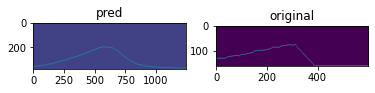

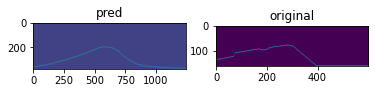

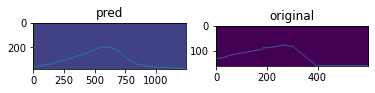

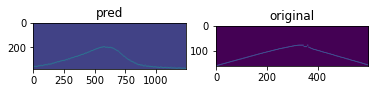

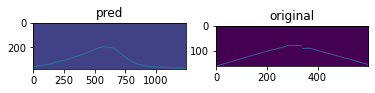

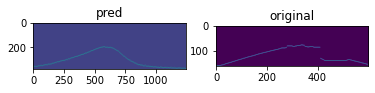

In [17]:
previous_image = np.expand_dims(resized_input_image_array_np[0, :, :, :], 0)
previous_pred = resized_model.predict(previous_image).reshape(1,600)
for i in range(resized_input_image_array_np.shape[0]):
    if i > 5:
        break
    image_to_predict = np.expand_dims(resized_input_image_array_np[i, :, :, :], 0)
    image_label_being_predicted = resized_label_array_np[i,:].reshape(1,600)
#     print(image_to_predict.shape)
#     print(image_label_being_predicted.shape)
    prediction = resized_model.predict(image_to_predict)
#     print(prediction.shape)
    # print(prediction)
    if np.array_equiv(previous_image, image_to_predict):
        print("BAHHHHH")
    if np.array_equiv(previous_pred, prediction):
        print("BOOOOOO")
#         print(prediction)
    previous_image = image_to_predict
    previous_pred = prediction
    image_pred = np.zeros([160,600,1])
    image = np.zeros([160,600,1])
#     print(image.shape)
    for col_num in range(600):
        image_pred[int(prediction[0][col_num]-1), col_num, 0] = 1
        image[int(image_label_being_predicted[0][col_num]-1), col_num, 0] = 1

    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(cv2.resize(image_pred, dsize=(1242, 375), interpolation=cv2.INTER_CUBIC))
    ax1.set_title("pred")
    ax2.imshow(image)
    ax2.set_title("original")

In [21]:
if not load_model_from_file:

    # Create the models
    tf.keras.backend.clear_session()
    cropped_model = create_model()
    
    # Train the model
#     history = cropped_model.fit(cropped_input_image_array_np, cropped_label_array_np, epochs=1)
    history = cropped_model.fit(cropped_input_image_array_np, cropped_label_array_np, epochs=8)
    if not os.path.isdir("models"):
        os.mkdir("models")
    model_loss = int(history.history['loss'][-1])
    cropped_model.save(os.path.join("models", "cropped_model_loss_{}_time_{}.h5".format(model_loss, datetime.utcnow().strftime("%Y_%m_%d_%H_%M_%S"))))

# Check dem summaries
# cropped_model.summary()


Train on 289 samples
289/289 [==============================] - 116s 401ms/sample - loss: 18121.4279 - acc: 0.0830


In [19]:
if load_model_from_file:
    for path in os.listdir("models"):
        if "cropped_model" in path:
            print("Loading model from file {}".format(path))
            cropped_model = keras.models.load_model(path)
            break

In [25]:
train_loss = int(history.history['loss'][-1])
# acc = History.history['accuracy']
print(train_loss)

18121
